In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score,confusion_matrix
from ucimlrepo import fetch_ucirepo
from sklearn.feature_selection import mutual_info_classif

In [51]:
dataframe = pd.read_csv('B1.csv')
dataframe

,X1,X2,y
0,0.021149,0.418246,1
1,0.173735,-0.993524,0
2,0.251041,0.447588,1
3,0.458603,0.866472,0
4,-0.281439,-0.444892,1
...,...,...,...
2995,0.491668,0.427125,1
2996,-0.083604,-1.041848,0
2997,-0.064109,-1.031312,0
2998,0.771608,-0.793978,0


In [52]:
X = dataframe[['X1', 'X2']].values
y = dataframe['y'].values

In [53]:
dataframe = dataframe.replace("", np.nan)
dataframe = dataframe.replace("?", np.nan)

In [54]:
dataframe.isnull().sum()


X1    0
X2    0
y     0
dtype: int64

In [55]:
dataframe[dataframe.duplicated(keep=False)]

,X1,X2,y


In [56]:
#encoding and scaling
def encoding_scaling(features,target):
        #label encoding
        encoder = LabelEncoder()
        target = encoder.fit_transform(target)
        
        #one hot encoding
        # List of columns to convert to categorical
        object_columns = features.select_dtypes(include=['object'])
        # Convert each column to categorical type
        for col in object_columns:
            features[col] = features[col].astype('category')
        features = pd.get_dummies(features)
        
        #minmax scaling
        scaler = MinMaxScaler()
        
        selected = features.select_dtypes(exclude=['bool']).columns

        features_minmax = features.copy()
        features_minmax[selected] = scaler.fit_transform(features[selected])
        return features_minmax,target

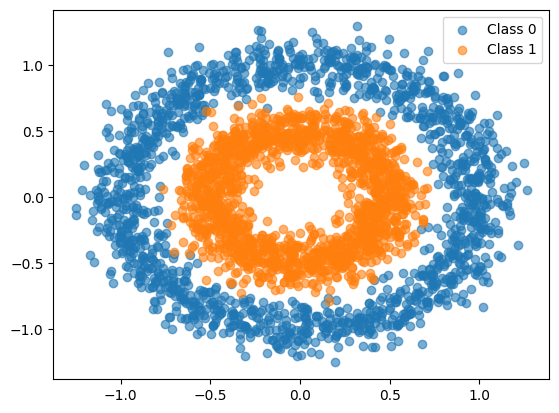

In [57]:
import matplotlib.pyplot as plt
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 0', alpha=0.6)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 1', alpha=0.6)
plt.legend()
plt.show()

In [58]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
        

In [59]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Logistic regression model
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, regularization=None, lambda_=0.01):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.regularization = regularization  # 'l1', 'l2', or None
        self.lambda_ = lambda_  # Regularization strength
    
    
    def fit(self, X, y):
        num_samples, num_features = X.shape
        
        
        self.weights = np.zeros(num_features)
        self.bias = 0
        
        
        for _ in range(self.num_iterations):
            # Linear model: z = Xw + b
            z = np.dot(X, self.weights) + self.bias
            
            # Sigmoid function
            y_pred = sigmoid(z)
            
            # Compute the gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)
            
            # Apply regularization
            if self.regularization == "l2":
                # L2 Regularization (Ridge): Add lambda * weights to dw
                dw += (self.lambda_ / num_samples) * self.weights
            elif self.regularization == "l1":
                # L1 Regularization (Lasso): Add lambda * sign(weights) to dw
                dw += (self.lambda_ / num_samples) * np.sign(self.weights)
            
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    # binary outcomes (0 or 1)
    def predict(self, X):
        # Linear model: z = Xw + b
        z = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(z)
        # Convert probabilities to binary predictions (0 or 1)
        return [1 if i > 0.5 else 0 for i in y_pred]
    
def accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    accuracy = correct_predictions / len(y_true)
    return accuracy

X_train,X_test,y_train,y_test=train_test_split(X_scaled,y, test_size=0.2,random_state=42)

y_train = y_train.ravel()  
y_test = y_test.ravel()    

model = LogisticRegression(learning_rate=0.1, num_iterations=1000, regularization='l2', lambda_=0.01)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")


model.fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy(y_test, predictions)
sensitivity = recall_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
specificity = tn / (tn + fp)
precision = precision_score(y_test, predictions)
f_1_score = f1_score(y_test, predictions)
auroc_score = roc_auc_score(y_test, predictions)
aupr = average_precision_score(y_test, predictions)

print(f"Accuracy: {acc}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1 Score: {f_1_score}")
print(f"AUROC: {auroc_score}")
print(f"AUPR: {aupr}")

Shape of X_train: (2400, 2)
Shape of y_train: (2400,)
Accuracy: 0.56
Sensitivity: 0.9963235294117647
Specificity: 0.19817073170731708
Precision: 0.5074906367041199
F1 Score: 0.6724565756823822
AUROC: 0.5972471305595408
AUPR: 0.507291528971139


In [60]:
num_bagging_samples = 9

logistic_models = []
for i in range(num_bagging_samples):
    # Create a bootstrap sample
    bagging_indices = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
    X_bootstrap = X_train[bagging_indices]
    y_bootstrap = y_train[bagging_indices]

    # Train a new Logistic Regression model on the bootstrap sample
    model = LogisticRegression(learning_rate=0.1, num_iterations=1000, regularization='l2', lambda_=0.01)
    model.fit(X_bootstrap, y_bootstrap)
    
    # Append the trained model to the array
    logistic_models.append(model)
def aggregate_predictions(models, X_test):
    
    predictions = []
    for model in models:
        predictions.append(model.predict(X_test))
    
    
    predictions = np.array(predictions)
    
    
    final_predictions = np.round(np.mean(predictions, axis=0))  # Majority voting
    return final_predictions

# final predictions using the aggregate predictions from all models
final_predictions = aggregate_predictions(logistic_models, X_test)


bagging_acc = accuracy(y_test, final_predictions)
print(f"Bagging Logistic Regression Accuracy: {bagging_acc:.2f}")



Bagging Logistic Regression Accuracy: 0.53


In [61]:
accuracy_list = []
precision_list = []
f1_list = []
sensitivity_list = []
specificity_list = []
auroc_list = []
aupr_list = []

# Evaluate each bagged Logistic Regression model
for model in logistic_models:
    # Get predictions for each model on the test set
    y_pred = model.predict(X_test)
    
    
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))
    sensitivity_list.append(recall_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity_list.append(tn / (tn + fp))
    auroc_list.append(roc_auc_score(y_test, y_pred))
    aupr_list.append(average_precision_score(y_test, y_pred))
    

# Convert the lists to NumPy arrays
accuracy_list = np.array(accuracy_list)
precision_list = np.array(precision_list)
f1_list = np.array(f1_list)
sensitivity_list = np.array(sensitivity_list)
specificity_list = np.array(specificity_list)
auroc_list = np.array(auroc_list)
aupr_list = np.array(aupr_list)

d:\LEVEL 4 TERM 2\CSE 472\Assignment 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


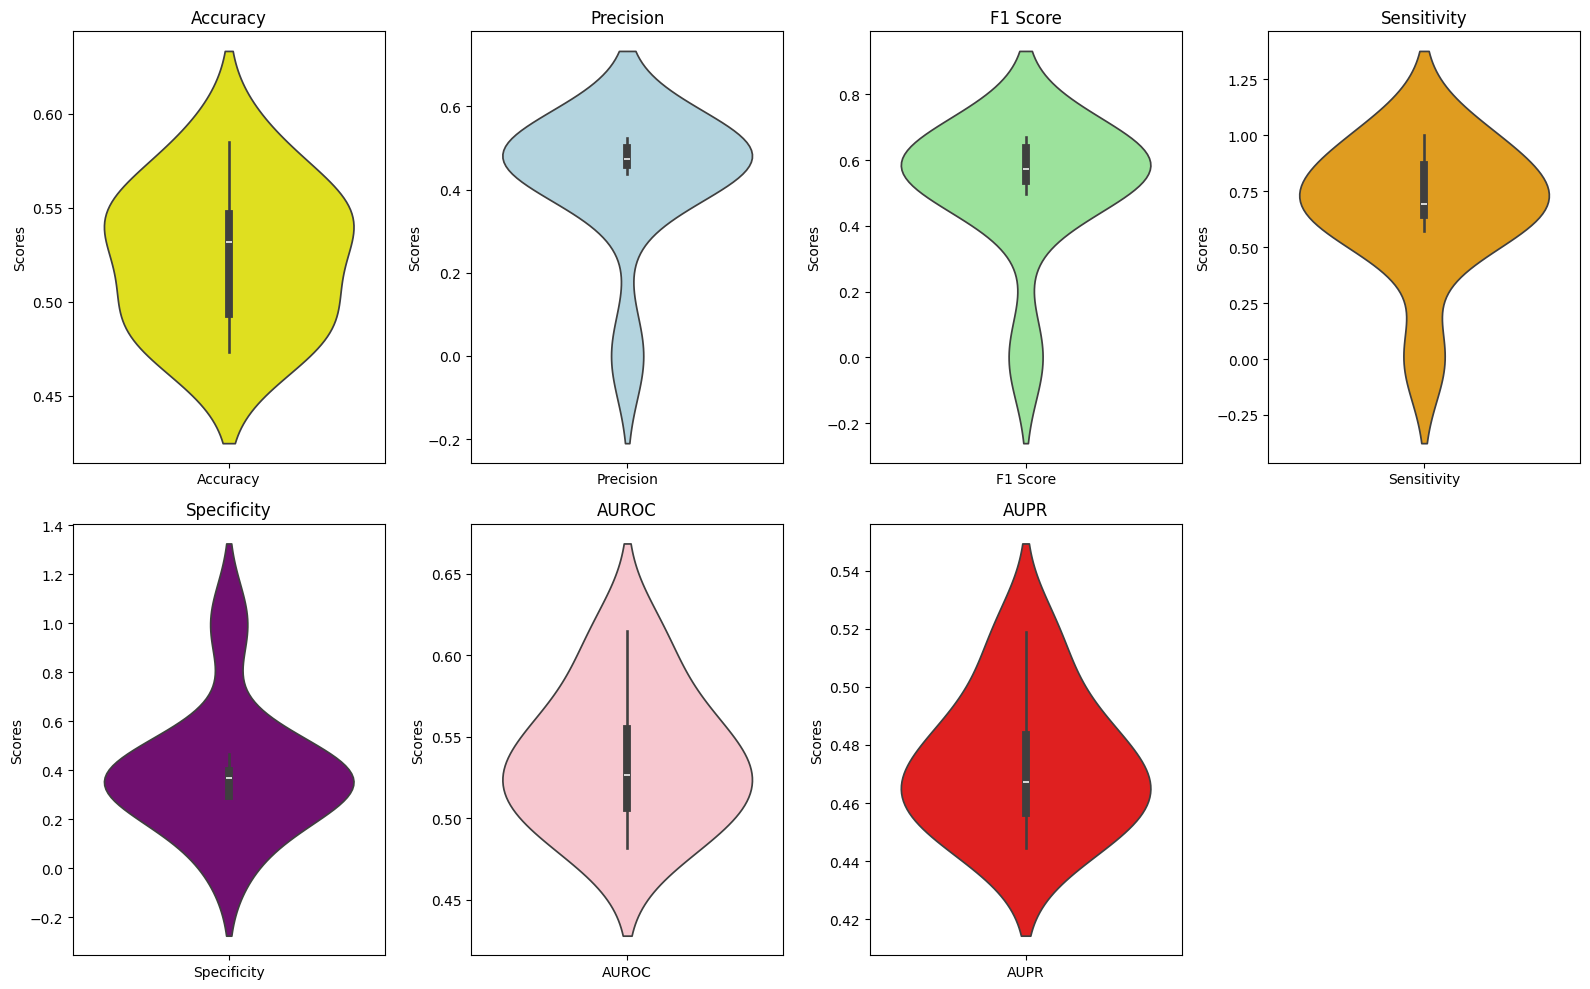

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame to store all performance metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'F1 Score': f1_list,
    'Sensitivity' : sensitivity_list,
    'Specificity' : specificity_list,
    'AUROC' : auroc_list,
    'AUPR' : aupr_list
})

metrics = ['Accuracy', 'Precision', 'F1 Score', 'Sensitivity', 'Specificity', 'AUROC', 'AUPR']
colors = ['yellow', 'lightblue', 'lightgreen', 'orange', 'purple', 'pink', 'red']

fig, axes = plt.subplots(2, 4, figsize=(16, 10))  # 2 rows and 4 columns layout
axes = axes.flatten()  # Flatten the axes array


for i, metric in enumerate(metrics):
    sns.violinplot(data=metrics_df[[metric]], ax=axes[i], color=colors[i])
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel('Scores')
    axes[i].set_xlabel('')

# Remove the extra subplot (as we have 7 metrics but 8 subplots)
fig.delaxes(axes[-1])


plt.tight_layout()
plt.show()

In [63]:
X_base_train, X_meta_train_split, y_base_train, y_meta_train_split = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

def generate_meta_features(models, X):
    meta_features = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        meta_features[:, i] = model.predict(X)
    return meta_features

X_meta_train = generate_meta_features(logistic_models, X_meta_train_split)
X_meta_test = generate_meta_features(logistic_models, X_test)

# Concatenate X_meta_train and X_meta_train_split
X_meta_combined = np.concatenate((X_meta_train, X_meta_train_split), axis=1)
X_meta_combined_test = np.concatenate((X_meta_test, X_test), axis=1)

# print(X_meta_train.shape)
# print(X_meta_train_split.shape)
# print(X_meta_combined.shape)
# print(X_meta_test.shape)
# print(X_test.shape)
# print(f"y_meta_train_split shape: {y_meta_train_split.shape}")

# Train a Logistic Regression model on the meta features

meta_model = LogisticRegression(learning_rate=0.1, num_iterations=1000, regularization='l2', lambda_=0.01)
meta_model.fit(X_meta_combined, y_meta_train_split)
meta_predictions = meta_model.predict(X_meta_combined_test)
stacking_acc = accuracy(y_test, meta_predictions)
print(f"Stacking Ensemble Accuracy: {stacking_acc:.2f}")

sensitivity = recall_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
specificity = tn / (tn + fp)
precision = precision_score(y_test, predictions)
f_1_score = f1_score(y_test, predictions)
auroc_score = roc_auc_score(y_test, predictions)
aupr = average_precision_score(y_test, predictions)

print(f"Accuracy: {stacking_acc}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1 Score: {f_1_score}")
print(f"AUROC: {auroc_score}")
print(f"AUPR: {aupr}")

Stacking Ensemble Accuracy: 0.72
Accuracy: 0.72
Sensitivity: 0.9963235294117647
Specificity: 0.19817073170731708
Precision: 0.5074906367041199
F1 Score: 0.6724565756823822
AUROC: 0.5972471305595408
AUPR: 0.507291528971139


In [64]:
# Majority Voting
def majority_voting(models, X_test):
    # Collect predictions from all models
    predictions = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X_test)
    
    
    final_predictions = np.round(np.mean(predictions, axis=1))
    return final_predictions

voting_predictions = majority_voting(logistic_models, X_test)


voting_acc = accuracy(y_test, voting_predictions)

sensitivity = recall_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
specificity = tn / (tn + fp)
precision = precision_score(y_test, predictions)
f_1_score = f1_score(y_test, predictions)
auroc_score = roc_auc_score(y_test, predictions)
aupr = average_precision_score(y_test, predictions)

print(f"Accuracy: {voting_acc}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1 Score: {f_1_score}")
print(f"AUROC: {auroc_score}")
print(f"AUPR: {aupr}")

Accuracy: 0.5266666666666666
Sensitivity: 0.9963235294117647
Specificity: 0.19817073170731708
Precision: 0.5074906367041199
F1 Score: 0.6724565756823822
AUROC: 0.5972471305595408
AUPR: 0.507291528971139
